In [1]:
import os
import sys
MAIN_PATH = os.path.dirname(os.getcwd())

sys.path.insert(0, MAIN_PATH)

from utils.utils import extract_mel_spectrogram
from audiomentations import AddBackgroundNoise
import numpy as np
import torch
from models.neural_fingerprinter import Neural_Fingerprinter
import matplotlib.pyplot as plt
import librosa

/home/chrisnick/miniconda3/envs/deep_fingerprinting/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
song_1 = 'Madonna - Sorry.npy'
song_2 = 'Wolfgang Amadeus Mozart - The Magic Flute Queen of the Night Aria.npy'

fp_path = os.path.join(MAIN_PATH, 'data/fingerprints_new')

f1 = np.load(os.path.join(fp_path, song_1))
f2 = np.load(os.path.join(fp_path, song_2))

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(np.concatenate((f1, f2), axis=0))
X.shape

(940, 2)

In [4]:
y, sr = librosa.load(
    os.path.join(
        MAIN_PATH, 'data/small_dataset/demo_songs/Wolfgang Amadeus Mozart - The Magic Flute Queen of the Night Aria.wav'
    ),
    sr=8000,
    duration=5,
    offset=120
)

b_noise = AddBackgroundNoise(
    os.path.join(MAIN_PATH, 'data/background_test/noise-street.wav'), min_snr_in_db=0, max_snr_in_db=0, p=1
)

y_noise = b_noise(y, sample_rate=sr)

In [5]:
model = Neural_Fingerprinter()
model.load_state_dict(torch.load(os.path.join(MAIN_PATH, 'data/pretrained_models/fingerprinter_beast.pt')))

<All keys matched successfully>

In [6]:
F, H = 8000, 4000

model.eval()
J = int(np.floor((y_noise.size - F) / H)) + 1
with torch.no_grad():
    xq = np.stack([extract_mel_spectrogram(y_noise[j * H:j * H + F]).reshape(1, 256, 32) for j in range(J)])
    query_fingerprints = model(torch.from_numpy(xq)).numpy()

print(query_fingerprints.shape)

(9, 128)


In [7]:
queries = pca.transform(query_fingerprints)
print(queries.shape)

(9, 2)


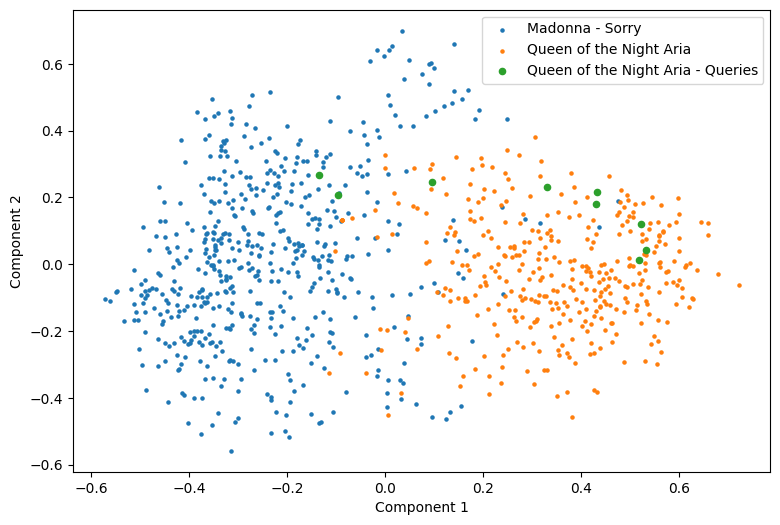

In [11]:
fig, ax = plt.subplots(figsize = (9, 6))

ax.scatter(x=X[:f1.shape[0]][:, 0], y= X[:f1.shape[0]][:, 1], label='Madonna - Sorry', s=5)

ax.scatter(x=X[f1.shape[0]:][:, 0], y= X[f1.shape[0]:][:, 1], label='Queen of the Night Aria', s=5)

ax.scatter(x=queries[:, 0], y=queries[:, 1], label='Queen of the Night Aria - Queries', s=20)

ax.legend()

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

plt.savefig(os.path.join(MAIN_PATH, 'images/test_representation.pdf'), format='pdf')
plt.show()